# Classificador de Fake News e proposta para não-proliferação das mesmas

   O assunto de Fake News está em alta na mídia já a um bom tempo, e teve seu pico quando o presidente dos Estados Unidos, Donald Trump, com a sua conta de Twitter, começou a disseminar a palavra sobre supostos sites de notícias que lançavam "notícias falsas". Tendo em mente isso, visamos a criar um programa utilizando de Machine Learning que faz o trabalho de decidir, utilizando a base de Natural Language Processing (NLP), se uma notícia realmente é falsa ou não. Para isso, este Notebook estará dividido nas seguintes partes: 
  - Pré-Processamento
  - Análise Exploratória dos Dados
  - Aplicação do Modelo de Machine Learning 
  - Validação e conclusão do Modelo

## Importação de libraries e de dados

In [77]:
import pandas as pd
import numpy as np
import seaborn as sb
import simplejson
import matplotlib.pyplot as plt
import matplotlib as plot
import re
from tqdm import tqdm 
from goose3 import Goose
from nltk.corpus import stopwords
import unicodedata
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer 
from gensim.models.tfidfmodel import TfidfModel
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from bs4 import BeautifulSoup

In [3]:
# Importamos uma certa quantia de dados do nosso arquivo json.

data_raw = []
num_data = 6000000
with open('data/fake-news-tera.json') as file:
    for i in tqdm(range(num_data)):
        x = 3
        if i%x==0:
            line = next(file)
            data_raw.append(simplejson.loads(line))
        
df_raw = pd.DataFrame(data_raw)

100%|██████████| 6000000/6000000 [03:11<00:00, 31332.46it/s]


## Analise Exploratoria

In [40]:
#Verificando o numero de tweets com o pais nulo
df_raw["location_country"].isna().sum()

683911

In [42]:
#Verificando os tweets de pais nulo
df_null = df_raw[df_raw["location_country"].isna()]

#Olhando os 10 primeiros tweets, foi verificado que a origem deles sao o Brasil, portanto mudaremos para Brasil
df_null['content'].value_counts()[:10]

RT @amandajustlaugh: no whatsapp:\n- o que aconteceu?\n- nada não.....\n\nno twitter:\n- e o filho da puta ainda vem me perguntar no whatsapp o que aconteceu                                  5348
RT @dougraz: no whatsapp:\ndeboa, não fiquei brabo não kkk \n\nno twitter https://twitter.com/rayllacampi/status/933128221318664193                                                            2725
RT @lelispatricia: Bolsonaro disse que não fala sobre economia porque não é economista, mas vive falando de gay... ahhhhhhh, entendi!                                                          1695
RT @comunacritico: A melhor definição que já li sobre o Bolsonaro e seus seguidores https://twitter.com/comunacritico/status/925858240868638720/photo/1                                        1493
RT @mlaudeauser: 1940: Código Penal permite que mulheres abortem em caso de estupro e risco de vida para a mãe.\n\n2017: o Congresso q… https://twitter.com/i/web/status/928380523654852608    1396
RT @majutrindade: qu

In [59]:
#Setando os paises nulos para Brasil
df_raw['location_country'].fillna(value = "Brasil", inplace=True)

In [74]:
#Analise dos paises que mais tweetaram
df_paises = df_raw['location_country'].value_counts()[:10]
df_paises = pd.DataFrame(df_paises)
df_paises

,location_country
Brasil,1777623
Estados Unidos,44616
Portugal,41725
Suíça,23341
Canada,14053
França,7500
Espanha,7403
Índia,5952
Reino Unido,5550
Itália,4756


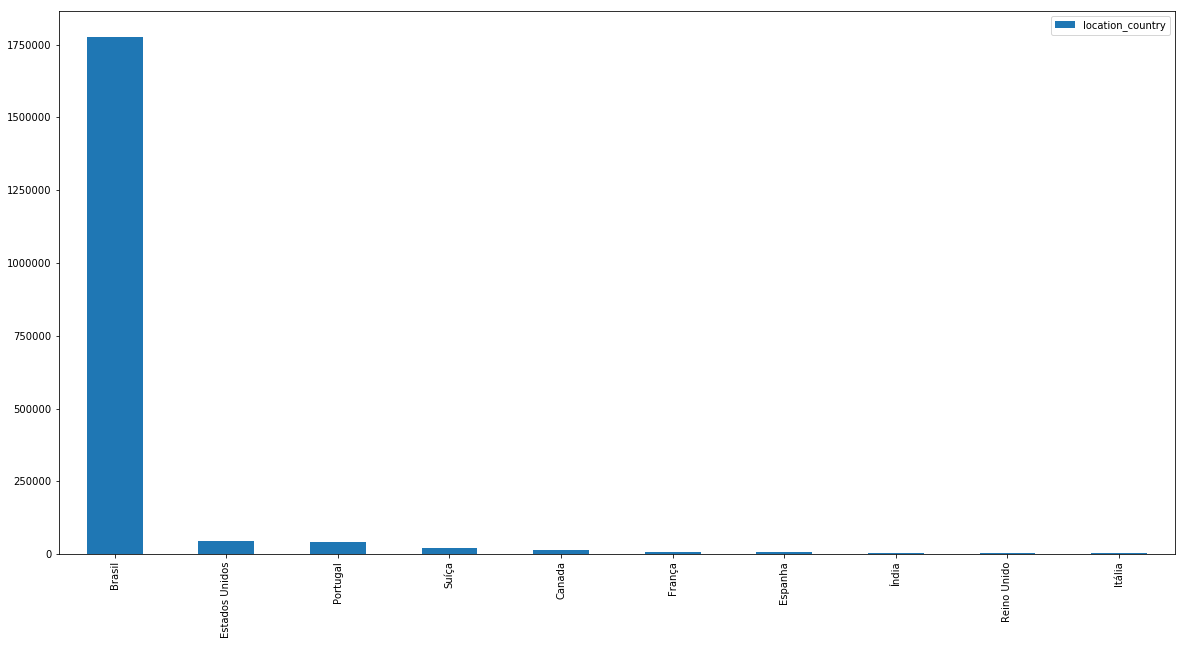

In [89]:
df_paises.plot(kind="bar", figsize=(20,10))
plt.show()

In [149]:
df_retweet = df_raw["related_tweet_url"].value_counts()
df_retweet = pd.DataFrame(df_retweet)
df_retweet = df_retweet.reset_index()
df_retweet = df_retweet.rename(columns = {"related_tweet_url":"number_activity"})
df_retweet = df_retweet.rename(columns = {"index":"related_tweet_url"})

In [181]:
df_activity =  df_raw.merge(df_retweet, how="inner", left_on="url", right_on="related_tweet_url")  

df_activity = df_activity[["profile_name","profile_followers","profile_following", "number_activity"]]

df_activity = df_activity.sort_values("number_activity", ascending=False)

df_activity.head(20)

,profile_name,profile_followers,profile_following,number_activity
298,Estadão,5870567.0,64904.0,2308
1006,Estadão,5880672.0,64887.0,529
4547,Gazeta Online,252785.0,2673.0,387
4267,Estadão,5884752.0,64881.0,384
2563,Estadão,5887991.0,64880.0,301
1589,Estadão,5878739.0,64889.0,291
3772,Folha de S.Paulo,6102286.0,187371.0,270
3959,André Trigueiro,218474.0,532.0,263
4056,Estadão,5889144.0,64874.0,244
3379,Estadão,5883281.0,64883.0,228


In [164]:
df_activity.isna().any()

profile_name         False
profile_followers    False
profile_following    False
number_activity      False
dtype: bool

## Pré-processamento

In [3]:
# Primeira olhada nos nossos dados

df_raw.head()

,app,content,date,location_city,location_country,location_lat,location_lng,location_state,profile_avatar,profile_description,...,profile_location,profile_login,profile_name,profile_url,profile_web,related_tweet_content,related_tweet_date,related_tweet_url,source,url
0,Facebook,Veja o passo a passo: http://fb.me/CK6knq9W,2017-10-31T06:00:03.000Z,Brás de Pina,Brasil,-22.832979,-43.297668,Rio de Janeiro,https://pbs.twimg.com/profile_images/339749594...,"Em breve, o melhor GUIA TURÍSTICO do Rio | Soo...",...,Rio de Janeiro (BR),amigonorio,Amigo no Rio,https://twitter.com/amigonorio,http://www.amigonorio.com.br,None,None,None,0,https://twitter.com/608352107/statuses/9252409...
1,Twitter for iPhone,@maika_1020 BAND MAIDのchoose me(｡>人<),2017-11-01T05:59:13.000Z,None,None,NaN,NaN,None,https://pbs.twimg.com/profile_images/920977346...,MOSHIMO SILENT SIREN sevenoops,...,None,msyn_711,まっしゃん,https://twitter.com/msyn_711,None,None,None,None,0,https://twitter.com/621782721/statuses/9256031...
2,Twitter Web Client,"É DONO DO STF. ONDE TODOS SÃO COVARDES, CONFOR...",2017-11-01T06:00:04.000Z,None,Brasil,-10.000000,-55.000000,None,https://pbs.twimg.com/profile_images/919944565...,"QUANDO OS QUE COMANDAM PERDEM A VERGONHA,OS CO...",...,Brasil,CarlitoMoraes,Carlito Moraes,https://twitter.com/CarlitoMoraes,None,Absurdo ... Gilmar se sente o dono do Brasil ....,2017-10-31T14:19:45.000Z,https://twitter.com/887707008/statuses/9253666...,0,https://twitter.com/346220548/statuses/9256033...
3,Twitter Lite,porra a globo corta se fodrrrr,2017-11-03T05:59:52.000Z,Santos,Brasil,-23.856630,-46.270550,São Paulo,https://pbs.twimg.com/profile_images/925930977...,musa de Alceu Valença•\n@justinbieber💙,...,baixada santista,ingcarvalh0,dindi,https://twitter.com/ingcarvalh0,https://www.instagram.com/morena7ropicana/?hl=...,None,None,None,0,https://twitter.com/1315339214/statuses/926328...
4,Twitter Lite,@UOL Deviam ter deixado mata-lo,2017-11-05T05:58:10.000Z,None,None,NaN,NaN,None,https://pbs.twimg.com/profile_images/905322029...,enfrentando novos desafios e vivendo um dia de...,...,None,wall2013,wall2013,https://twitter.com/wall2013,http://walterdesouza2012.blogspot.com.br/,None,None,None,0,https://twitter.com/1172898380/statuses/927052...


In [4]:
# Para nossa análise, foi concluído que não precisamos de algumas das colunas de nosso DataFrame, então foram tiradas:

df_clean = df_raw.drop(['app', 'location_city', 'location_country', 'location_lat', 'location_lng', 'location_state', 'profile_avatar', 'profile_location', 'profile_name', 'profile_web', 'related_tweet_date'], axis=1)
df_clean.head()

,content,date,profile_description,profile_followers,profile_following,profile_login,profile_url,related_tweet_content,related_tweet_url,source,url
0,Veja o passo a passo: http://fb.me/CK6knq9W,2017-10-31T06:00:03.000Z,"Em breve, o melhor GUIA TURÍSTICO do Rio | Soo...",18.0,15.0,amigonorio,https://twitter.com/amigonorio,None,None,0,https://twitter.com/608352107/statuses/9252409...
1,@maika_1020 BAND MAIDのchoose me(｡>人<),2017-11-01T05:59:13.000Z,MOSHIMO SILENT SIREN sevenoops,695.0,674.0,msyn_711,https://twitter.com/msyn_711,None,None,0,https://twitter.com/621782721/statuses/9256031...
2,"É DONO DO STF. ONDE TODOS SÃO COVARDES, CONFOR...",2017-11-01T06:00:04.000Z,"QUANDO OS QUE COMANDAM PERDEM A VERGONHA,OS CO...",5694.0,4225.0,CarlitoMoraes,https://twitter.com/CarlitoMoraes,Absurdo ... Gilmar se sente o dono do Brasil ....,https://twitter.com/887707008/statuses/9253666...,0,https://twitter.com/346220548/statuses/9256033...
3,porra a globo corta se fodrrrr,2017-11-03T05:59:52.000Z,musa de Alceu Valença•\n@justinbieber💙,2641.0,1098.0,ingcarvalh0,https://twitter.com/ingcarvalh0,None,None,0,https://twitter.com/1315339214/statuses/926328...
4,@UOL Deviam ter deixado mata-lo,2017-11-05T05:58:10.000Z,enfrentando novos desafios e vivendo um dia de...,159.0,953.0,wall2013,https://twitter.com/wall2013,None,None,0,https://twitter.com/1172898380/statuses/927052...


In [5]:
# Vemos o shape de nossos dados e suas características

print('Shape:\n')
print(df_clean.shape)
print(10*'-')
print('Contagem de NaN:\n')
print(df_clean.isna().sum())
print(10*'-')
print('Contagem de Null:\n')
print(df_clean.isnull().sum())
print(10*'-')

Shape:

(500000, 11)
----------
Contagem de NaN:

content                       0
date                          0
profile_description      110229
profile_followers          8089
profile_following          8089
profile_login                 0
profile_url                   0
related_tweet_content    460262
related_tweet_url        460262
source                        0
url                           0
dtype: int64
----------
Contagem de Null:

content                       0
date                          0
profile_description      110229
profile_followers          8089
profile_following          8089
profile_login                 0
profile_url                   0
related_tweet_content    460262
related_tweet_url        460262
source                        0
url                           0
dtype: int64
----------


Quando analisamos os dados acima, podemos ver que aproximadamente 90% dos dados não tem 'related_tweet_content', porém não é bom tira-los do nosso dataset, pois é um dos lugares aonde é possível puxar a URL da notícia que queremos.

### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 

In [6]:
# Iremos então separar o dataset em dois: o primeiro é aonde o source=0 (tweets), e outro aonde source=2 (RSS)

df_s0 = df_clean[df_clean['source'] == 0]
df_s0 = df_s0.reset_index()

df_s2 = df_clean[df_clean['source'] == 2]
df_s2 = df_s2.reset_index()
df_s2 = df_s2.drop(['index','profile_description','date', 'profile_followers', 'profile_following', 'related_tweet_content', 'source', 'related_tweet_url'], axis=1)
df_s2.shape[0]

8089

In [7]:
# # Para que possamos analisar as notícias mencionadas nos tweets em nosso dataset, precisamos da URL da mesma
# # Assim, criamos uma função para receber uma STRING e retornar o link contido na mesma. Caso não haja, retorna None

# def find_url(raw):
#     if raw == None:
#         return None
#     txt = re.search('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', raw)
#     if txt:
#         return txt.group()
#     else:
#         return None

In [8]:
# E então, analisando os dados, vimos que o link para a notícia pode estar tanto na coluna 'content' quanto na de
# 'related_tweet_content', portanto para criar a coluna 'URL', contento as URL que posteriormente tem que ser ana-
# lisadas, checamos primeiramente se há na 'related_tweet_content', depois no 'content', se existirem

# df_clean['URL'] = None # Coluna de URL, que será atualizada 
# for i in tqdm(range(num_data)):
#     cont = find_url(df_clean['content'][i])
#     re_cont = find_url(df_clean['related_tweet_content'][i])
#     if find_url(str(re_cont)) != None:
#         df_clean.loc[i, 'URL'] = re_cont
#     elif cont != None:
#         df_clean.loc[i, 'URL'] = cont
#     else:
#         df_clean.loc[i, 'URL'] = None

# df_clean['URL'].head() # Verificação do output

In [9]:
# Agora, de cada URL precisamos pegar o corpo do texto. Para nossa sorte, a biblioteca goose3 tem um módulo que 
# faz exatamente isso para nós. :) 
# Note que esse processo é demorado. 

# df_clean['Article'] = None
# g = Goose()
# for i in tqdm(range(num_data)):
#     url = df_clean.loc[i, 'URL']
#     if not(url):
#         df_clean.loc[i, 'Article'] = None
#     else:
#         try:
#             article = g.extract(url=url)
#             df_clean.loc[i, 'Article'] = article.cleaned_text
#         except:
#             df_clean.loc[i, 'Article'] = None

In [10]:
# Pegamos então o corpo de texto quando source=2 (RSS)
txt = ''
for i in tqdm(range(df_s2.shape[0])):
    txt = str(txt)+' '+str(BeautifulSoup(df_s2.loc[i, 'content'], 'html5lib').get_text())
    
txt[:100]

100%|██████████| 8089/8089 [00:27<00:00, 298.88it/s]


'  O labirinto dos espíritos (O cemitério dos livros esquecidos) Carlos Ruiz Zafón (Autor), Ari Roitm'

In [11]:
## Confirmamos nossa nova coluna
#print(df_clean['Article'][:10])

In [13]:
# Como no português temos muitos caracteres especiais, precisamos normaliza-los.

nfkd_form = unicodedata.normalize('NFKD', txt)
only_ascii = nfkd_form.encode('ASCII', 'ignore')
txt = only_ascii.decode('utf-8')

txt[:200]

'  O labirinto dos espiritos (O cemiterio dos livros esquecidos) Carlos Ruiz Zafon (Autor), Ari Roitman (Tradutor), Paulina Wacht (Tradutor)  (17)Comprar novo:   R$ 9,48 (Visite a lista Mais vendidos e'

In [17]:
# Nisso, fazemos o pré-processamento do texto em uma função

def preprocessing_nlp(txt):
    letters_only = ''
    if txt:
        letters_only = str(letters_only)+' '+str(re.sub("\W+",           
                                                " ",                  
                                                txt))  
    lower_case = letters_only.lower()
    rmv_whitespace = lower_case.strip()
    words = rmv_whitespace.split()
    words = [w for w in tqdm(words) if not w in stopwords.words("portuguese") and w]
    stemming = SnowballStemmer("portuguese")
    words_stem = [stemming.stem(t) for t in words]
    return words_stem

#E então, testamos a função e vemos as palavras mais faladas

process = preprocessing_nlp(txt)
process

100%|██████████| 1577866/1577866 [07:54<00:00, 3325.91it/s]


['labirint',
 'espirit',
 'cemiteri',
 'livr',
 'esquec',
 'carl',
 'ruiz',
 'zafon',
 'autor',
 'ari',
 'roitman',
 'tradutor',
 'paulin',
 'wacht',
 'tradutor',
 '17',
 'compr',
 'nov',
 'r',
 '9',
 '48',
 'visit',
 'list',
 'vend',
 'loj',
 'kindl',
 'ver',
 'informaco',
 'confiav',
 'sobr',
 'posica',
 'atual',
 'dest',
 'produt',
 'cap',
 'isabel',
 'lobinh',
 'titul',
 'joa',
 'mai',
 'pint',
 '2016',
 'marc',
 '40',
 'anos',
 'fim',
 'icon',
 'visa',
 'revist',
 'improvavel',
 'pais',
 'grav',
 'problem',
 'econom',
 'apresent',
 'banc',
 'ar',
 'luxuos',
 'cor',
 'acid',
 'brilhant',
 'temat',
 'polit',
 'libert',
 'quis',
 'comemor',
 'publicaca',
 'fez',
 'ruptur',
 'bd',
 'tradicional',
 'portugues',
 'sobretud',
 'recuper',
 'assembl',
 'legisl',
 'min',
 'ger',
 'almg',
 'inic',
 'nest',
 'segund',
 'feir',
 '30',
 '10',
 '17',
 'encontr',
 'estadual',
 'discussa',
 'particip',
 'plan',
 'plurianual',
 'aca',
 'governamental',
 'ppag',
 '2017',
 '2019',
 'revisa',
 '2018',

In [20]:
## Agora faremos o processo de Bag of Words

def prepare_bow(wrds):
    docs = [doc.split() for doc in tqdm(wrds)]
    dictionary = Dictionary(docs)
    corpus = [dictionary.doc2bow(doc) for doc in tqdm(docs)]
    return corpus

# Testamos :) 

bow = prepare_bow(process)
print(bow[:5])

100%|██████████| 980886/980886 [00:05<00:00, 182311.85it/s]

[[(0, 1)], [(1, 1)], [(2, 1)], [(3, 1)], [(4, 1)]]


In [21]:
# Agora iremos fazer o nosso CountVectorizer, para posteriormente podermos colocar em um modelo. Assim, acabamos 
# nossa parte de pré-processamento até o ponto de CountVectorizer! :) 

vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000)  
train = vectorizer.fit(process)
train.vocabulary_

{'espirit': 1955,
 'cemiteri': 979,
 'livr': 2946,
 'esquec': 1961,
 'carl': 924,
 'autor': 661,
 '17': 41,
 'compr': 1175,
 'nov': 3338,
 '48': 130,
 'visit': 4932,
 'list': 2941,
 'vend': 4862,
 'loj': 2956,
 'ver': 4869,
 'informaco': 2619,
 'sobr': 4444,
 'posica': 3724,
 'atual': 636,
 'dest': 1584,
 'produt': 3839,
 'cap': 898,
 'isabel': 2727,
 'titul': 4657,
 'joa': 2770,
 'mai': 3003,
 'pint': 3652,
 '2016': 84,
 'marc': 3041,
 '40': 120,
 'anos': 455,
 'fim': 2197,
 'icon': 2498,
 'visa': 4930,
 'revist': 4175,
 'pais': 3474,
 'grav': 2405,
 'problem': 3830,
 'econom': 1759,
 'apresent': 512,
 'banc': 695,
 'ar': 528,
 'cor': 1336,
 'brilhant': 821,
 'temat': 4601,
 'polit': 3699,
 'libert': 2909,
 'quis': 3953,
 'comemor': 1130,
 'publicaca': 3912,
 'fez': 2174,
 'tradicional': 4689,
 'portugues': 3722,
 'sobretud': 4447,
 'recuper': 4024,
 'assembl': 584,
 'legisl': 2874,
 'min': 3159,
 'ger': 2342,
 'inic': 2627,
 'nest': 3302,
 'segund': 4327,
 'feir': 2151,
 '30': 104,
 